### 使用BertTokenizer进行文本向量化

In [291]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

import warnings
warnings.filterwarnings('ignore')

## 1、构造文本特征提取函数

In [292]:
## 文本向量化函数
## text_list 文本内容的list
## 返回一个字典，{'input_ids':value, 'token_type_ids':value, 'attention_mask':value},每个元素的长度等于len(text_list)
## "input_ids"-词转换为数字后的序列 'token_type_ids'-标记一段文本中不同句子的序号 'attention_mask'-标记填充位置的序号 
## reference: https://huggingface.co/docs/transformers/main/en/glossary
def text_tokenize(text_list): 
    tokenizer = BertTokenizer.from_pretrained('./bert-base-uncased',do_lower_case=True)
    encoded_text = tokenizer.batch_encode_plus(
        text_list,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )
    return encoded_text
## 'input_ids' 'token_type_ids' 'attention_mask'

In [293]:
## 文本向量化示例
temp_txt_list = ["Hello,my name is Jerry.","Hello,my name is Tom."]
temp_coded_txt = text_tokenize(temp_txt_list)
print(type(temp_coded_txt),len(temp_coded_txt),len(temp_coded_txt["input_ids"]))
len(temp_coded_txt["token_type_ids"][0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<class 'transformers.tokenization_utils_base.BatchEncoding'> 3 2


256

## 2、读入CSV文件示例

In [294]:
## 读入csv文件示例
## 由于我们的csv文件使用"#"分隔，需要定义sep参数为"#",否则会读取失败！！！
train_csv = pd.read_csv("./CSVfile/train.csv",sep="#")

In [295]:
train_csv.text.values[0]

'Excuse me.'

In [296]:
## 快速查看前5条数据
train_csv.head(5)

,num,id,path,text,label
0,1,Ses01F_impro01_F000,train/Ses01F_impro01_F000.wav,Excuse me.,2
1,2,Ses01F_impro01_F001,train/Ses01F_impro01_F001.wav,Yeah.,2
2,3,Ses01F_impro01_F002,train/Ses01F_impro01_F002.wav,Is there a problem?,2
3,4,Ses01F_impro01_F005,train/Ses01F_impro01_F005.wav,Well what's the problem? Let me change it.,2
4,5,Ses01F_impro01_F012,train/Ses01F_impro01_F012.wav,That's out of control.,0


In [297]:
## 统计该csv下lable列不同值的数量
train_csv.value_counts(subset="label")

label
2    1066
1     891
3     696
0     606
Name: count, dtype: int64

Text(0.5, 1.0, 'Train dataset sample distribution')

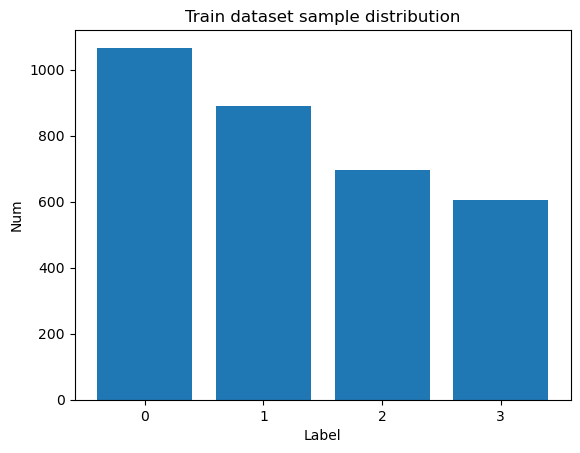

In [298]:
## 画图显示类别数
plt.bar([0,1,2,3],list(train_csv.value_counts(subset="label")),tick_label = ["0","1","2","3"])
plt.xlabel("Label")
plt.ylabel("Num")
plt.title("Train dataset sample distribution")

## 3、读取CSV文件、分离文件路径、文本内容、标签

In [299]:
## 读取train.csv、dev.csv
train_csv = pd.read_csv("./CSVfile/train.csv", sep = "#")
dev_csv = pd.read_csv("./CSVfile/dev.csv", sep = "#")
## 分离文件路径、文本内容和标签
## 训练时间较长，建议可以先截取部分样本进行代码正确性验证，再使用全部样本
train_path = list(train_csv.path)[:1500]
train_label = list(train_csv.label)[:1500]
train_txt = list(train_csv.text)[:1500]
dev_path = list(dev_csv.path)[:500]
dev_label = list(dev_csv.label)[:500]
dev_txt = list(dev_csv.text)[:500]

# train_path = list(train_csv.path)
# train_label = list(train_csv.label)
# train_txt = list(train_csv.text)
# dev_path = list(dev_csv.path)
# dev_label = list(dev_csv.label)
# dev_txt = list(dev_csv.text)

## 4、创建Data loaders

In [300]:
##  'input_ids' 'token_type_ids' 'attention_mask'
train_coded_txt = text_tokenize(train_txt)
dev_coded_txt = text_tokenize(dev_txt)
train_dataset = TensorDataset(train_coded_txt["input_ids"], 
                              train_coded_txt["attention_mask"],
                              torch.tensor(train_label))
dev_dataset = TensorDataset(dev_coded_txt["input_ids"], 
                            dev_coded_txt["attention_mask"],
                            torch.tensor(dev_label))
print(len(train_dataset),len(dev_dataset))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1500 500


In [301]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [302]:
## 这里的batch_size 可以从1、2、4、8、16...尝试，过大的batch_size会使训练过程因为显存不足失败
batch_size = 64
dataloader_train = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size
)
dataloader_dev = DataLoader(
    dev_dataset, sampler=RandomSampler(dev_dataset), batch_size=32
)

## 5、定义性能指标

In [303]:
import numpy as np
from sklearn.metrics import f1_score

In [304]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')

In [305]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {0:"angry",1:"happy or excited",2:"neutral",3:"sad"}
    # print(preds)
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [306]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [307]:
def calculate_score_classification(preds, labels, average_f1='macro'):  # weighted, macro
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average=average_f1, zero_division=0)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    ua = recall_score(labels, preds, average='macro', zero_division=0)
    confuse_matrix = confusion_matrix(labels, preds)
    return accuracy, ua, f1, precision, confuse_matrix

## 6、设置模型

In [308]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [309]:
class MyDLmodel:
    def __init__(self, model, device, patience=3):
        self.device = device
        self.patience = patience
        self.best_f1_score = 0
        self.early_stop_counter = 0

        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs.")
            self.model = torch.nn.DataParallel(model, device_ids=[0, 1])
        else:
            self.model = model

        self.model.to(self.device)
        self.optimizer = AdamW(
            self.model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.05
        )
        self.scheduler = None

    def train(self, dataloader_train, dataloader_dev, epochs):
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            for batch in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{epochs}"):
                batch = tuple(t.to(self.device) for t in batch)
                input_ids, attention_mask, labels = batch

                self.optimizer.zero_grad()
                outputs = self.model(
                    input_ids=input_ids, attention_mask=attention_mask, labels=labels
                )

                loss = outputs.loss.mean()
                total_loss += loss.item()
                loss.backward()
                self.optimizer.step()

            avg_train_loss = total_loss / len(dataloader_train)
            print(f"Training Loss: {avg_train_loss:.4f}")

            val_loss, val_f1 = self.evaluate(dataloader_dev)

            if val_f1 > self.best_f1_score:
                self.best_f1_score = val_f1
                self.early_stop_counter = 0
                torch.save(self.model.state_dict(), "best_model.pt")
                print("F1 Score increased, saving model.\n")
            else:
                self.early_stop_counter += 1
                print(
                    f"No improvement in F1 Score for {self.early_stop_counter} epoch(s).\n"
                )
                if self.early_stop_counter >= self.patience:
                    print(
                        f"Early stopping triggered at F1 Score: {self.best_f1_score:.4f}"
                    )
                    break

    def evaluate(self, dataloader_val):
        self.model.eval()
        total_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in dataloader_val:
                batch = tuple(t.to(self.device) for t in batch)
                input_ids, attention_mask, labels = batch

                outputs = self.model(
                    input_ids=input_ids, attention_mask=attention_mask, labels=labels
                )

                loss = outputs.loss.mean()
                logits = outputs.logits

                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_loss / len(dataloader_val)
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average="macro")
        print(
            f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}"
        )

        return avg_val_loss, f1

    def predict(self, dataloader_test):
        self.model.eval()
        try:
            self.model.load_state_dict(torch.load("best_model.pt"))
            print("Loaded best model for prediction.")
        except:
            print("No saved model found, using current model for prediction.")

        all_preds = []
        with torch.no_grad():
            for batch in dataloader_test:
                batch = tuple(t.to(self.device) for t in batch)
                input_ids, attention_mask = batch

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())

        return all_preds

In [310]:
import random
## 设置随机种子
def set_seeds(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [311]:
## test_preds 长度为1241的list，对应测试集中1241个样本的标签
##运行后会在当前目录生成result.csv文件，提交result.csv文件即可
##如果没有生成，请检查test_preds的长度是否为1241！
def write_result(test_preds):
    if len(test_preds) != 1241:
        print("错误！请检查test_preds长度是否为1241！！！")
        return -1
    test_csv = pd.read_csv("./CSVfile/test.csv",sep="#")
    test_csv["label"] = test_preds
    test_csv.to_csv("./result.csv",sep = "#")
    print("测试集预测结果已成功写入到文件中！")

In [312]:
from transformers import BertForSequenceClassification

In [313]:
# model reference： https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification
set_seeds(17)
pretrained_model = pretrained_model = BertForSequenceClassification.from_pretrained(
    "./bert-base-uncased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
mymodel = MyDLmodel(pretrained_model, device)
epochs = 15
mymodel.train(dataloader_train, dataloader_dev, epochs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
Using 2 GPUs.


Epoch 1/15: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


Training Loss: 1.2388
Validation Loss: 1.2513, Accuracy: 0.4300, F1 Score: 0.3996
F1 Score increased, saving model.



Epoch 2/15: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


Training Loss: 0.8841
Validation Loss: 1.2371, Accuracy: 0.5220, F1 Score: 0.5173
F1 Score increased, saving model.



Epoch 3/15: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]


Training Loss: 0.5713
Validation Loss: 1.1102, Accuracy: 0.6140, F1 Score: 0.6158
F1 Score increased, saving model.



Epoch 4/15: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


Training Loss: 0.3301
Validation Loss: 1.1426, Accuracy: 0.6040, F1 Score: 0.5980
No improvement in F1 Score for 1 epoch(s).



Epoch 5/15: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


Training Loss: 0.2289
Validation Loss: 1.3522, Accuracy: 0.6080, F1 Score: 0.6023
No improvement in F1 Score for 2 epoch(s).



Epoch 6/15: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


Training Loss: 0.1703
Validation Loss: 1.4373, Accuracy: 0.6240, F1 Score: 0.6285
F1 Score increased, saving model.



Epoch 7/15: 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]


Training Loss: 0.1391
Validation Loss: 1.3443, Accuracy: 0.6420, F1 Score: 0.6319
F1 Score increased, saving model.



Epoch 8/15: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


Training Loss: 0.1218
Validation Loss: 1.3085, Accuracy: 0.6500, F1 Score: 0.6400
F1 Score increased, saving model.



Epoch 9/15: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


Training Loss: 0.0986
Validation Loss: 1.5060, Accuracy: 0.6420, F1 Score: 0.6420
F1 Score increased, saving model.



Epoch 10/15: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


Training Loss: 0.0948
Validation Loss: 1.4932, Accuracy: 0.6320, F1 Score: 0.6277
No improvement in F1 Score for 1 epoch(s).



Epoch 11/15: 100%|██████████| 24/24 [00:13<00:00,  1.82it/s]


Training Loss: 0.0918
Validation Loss: 1.5832, Accuracy: 0.6500, F1 Score: 0.6357
No improvement in F1 Score for 2 epoch(s).



Epoch 12/15: 100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


Training Loss: 0.0961
Validation Loss: 1.6818, Accuracy: 0.6060, F1 Score: 0.6027
No improvement in F1 Score for 3 epoch(s).

Early stopping triggered at F1 Score: 0.6420


In [314]:
# ## 预测测试集标签
# test_csv = pd.read_csv("./CSVfile/test.csv",sep = "#")
# test_text = list(test_csv.text)
# test_coded_txt = text_tokenize(test_text)
# test_dataset = TensorDataset(
#     test_coded_txt["input_ids"], 
#     test_coded_txt["attention_mask"])
# dataloader_test = DataLoader(
#     test_dataset,
#     sampler=RandomSampler(test_dataset),
#     batch_size=32)
# test_preds = mymodel.predict(dataloader_test)
# ## 写入预测结果
# write_result(test_preds)